# Sum_Links files exploration and processing
La idea es levantar atributos para el dataset estandar

* observar estructura de la tabla 
* levantar solo los pares (i,j) donde i & j son users de la telco. Para saber si son users de la teclo es necesario levantar el file del hash_map (user_hash -- > int). Descartando asi el resto de los users.
* extraer features de uso "endemico" para nuestros users de la TelCo
* extraer la info por antena para usar luego en los mapas de mexico.

### Obs. este parseo de sum_links da informacion suficiente como para no mirar el file userData

## definiciones utilizadas
* timestamp arranca en 0 segundos para 01/01/2012 00:00am
* La Direction, viene dada relativa al user de la primer columna (incoming si entra y viceversa si es outgoing).
* los calls son un conteo de quantity.
* los usuarios de la Telco pueden venir en Origin o Target indistintamente
* el time se mide en segundos
* daylight time esta entre [7, 19) horas (exclusivo).
* ignoramos los sms, pues no podemos estar seguros de tener esta info en el dataset Argentino

### el dataset vendria con este header
 {'LineKeyOrigin':hash_object \\\  'LineKeyTarget':np.uint32 \\\  'CallsWeekDayLight':np.uint8 \\\   'CallsWeekNight':np.uint8 \\\  'CallsWeekend':np.uint8 \\\  'TimeWeekDaylight':np.uint8 \\\  'TimeWeekNight':np.uint8 \\\  'TimeWeekend':np.uint8 \\\  'SmsWeekDaylight':np.uint8 \\\  'SmsWeekNight ':np.uint8 \\\  'SmsWeekend':np.uint8} 

In [1]:
import pandas as pd; import numpy as np; import os;import random;
pd.set_option('display.max_rows', 300)
from matplotlib import pyplot as plt
%matplotlib inline
import unicodedata
import os
import random
import time

In [2]:
np.random.seed(2016)

In [3]:
#en user_hash_map va a quedar el mapping de hashes por usuario a su int correspondiente.

#users_hash_map= pd.read_csv('/home/juan/mobility-study/output_user_hash_map.txt.gz',
#                       sep = "|",
#                       header=0,
#                       index_col=0)

In [4]:
#seteamos el lugar de trabajo
rootdir="/grandata/voice/sum_links"
os.chdir(rootdir)
year = "2015"; 
month_start= "04";
#todos estos sum_links terminan 2 meses mas tardes
month_end= "0"+str(int(month_start)+2)
input_file= rootdir +"/sum_links_{y}{ms}_{y}{me}.txt.gz".format(y=year,ms=month_start,me=month_end)
output_file = "/home/juan/mobility-study/output_sum_links.txt"

In [6]:
!zcat $input_file | head -n10

LineKeyOrigin|LineKeyTarget|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend|SmsWeekDaylight|SmsWeekNight|SmsWeekend
CD5844F7EB2C00C63465E43B44EB9025|3F6FEB3BA73D7E51D906B19F1E0A9099|0|0|0|0|0|0|1|0|0
6AEE0F059A39A7E1CF90B93B5BE8E5AD|3F6FEB3BA73D7E51D906B19F1E0A9099|0|0|0|0|0|0|0|0|3
CD5844F7EB2C00C63465E43B44EB9025|21F587020D72C34131DDD04C0FCD6CFF|0|0|0|0|0|0|0|0|1
CD5844F7EB2C00C63465E43B44EB9025|796D132ECDF757CBCE8FB01DDA3891D6|0|0|0|0|0|0|1|0|0
5E8BADC0F256DEC1ACBB1AB2B77527E9|796D132ECDF757CBCE8FB01DDA3891D6|0|0|3|0|0|203|0|0|0
CD5844F7EB2C00C63465E43B44EB9025|5FA3B22C222AFFF5DFAAE7CFCAEBCA30|0|0|0|0|0|0|0|0|1
6B56A956E1A9E56BE4D90543C8706E76|5FA3B22C222AFFF5DFAAE7CFCAEBCA30|0|0|0|0|0|0|1|0|0
2752F0E0F8226FFF2A3189EB131330AC|46B254E4C1A98CECB4F3D52E66BB836D|1|0|1|196|0|36|0|0|0
2752F0E0F8226FFF2A3189EB131330AC|A954CAD047A827B6DEBA10BD797E7B16|10|4|9|1403|208|1416|0|0|0

gzip: stdout: Broken pipe


## Tests
Veamos cuantos usuarios de un sum_links file dado son users de la telco (por cuestiones de velocidad tomamos solo las filas iniciales)

In [234]:
!zcat "/home/juan/mobility-study/output2.txt.gz" | head -n10

USER,EXPOSED,ANTENNA_ID_0,COUNT_0,ANTENNA_ID_1,COUNT_1,ANTENNA_ID_2,COUNT_2,ANTENNA_ID_3,COUNT_3,ANTENNA_ID_4,COUNT_4,ANTENNA_ID_5,COUNT_5,ANTENNA_ID_6,COUNT_6,ANTENNA_ID_7,COUNT_7,ANTENNA_ID_8,COUNT_8,ANTENNA_ID_9,COUNT_9,EPIDEMIC,MOBILITY_DIAMETER
FFFF78CB080636632B2D1DE7A7BFAB03,False,3415,21,2969,5,1320,3,2471,3,1115,2,-1,65535,-1,65535,-1,65535,-1,65535,-1,65535,False,1063.14053495
FFFF51FDDD55A2E24D074DE30C4798E9,True,1207,15,1171,14,1820,9,583,8,2026,5,1066,4,1831,4,1625,2,401,1,825,1,False,520.065958971
FFFE1EDDA25369CBC467536FA6A787FD,True,1847,22,1753,14,1422,11,1028,10,765,9,3072,9,862,8,2463,7,1416,6,871,5,True,989.597851013
FFFD0A912A959CDFCFFAB2F93BFBA435,True,1407,18,1702,8,1613,6,1704,5,1394,3,1398,3,818,2,958,2,726,1,848,1,False,490.58538164
FFFCB235D6D917DDF350F5B11CCB0EE8,True,17,74,174,33,1123,4,1178,4,173,3,890,2,503,1,1039,1,1228,1,1327,1,True,1613.22560564
FFFC9EC4F662C44D3006BA69C9F0DE85,True,876,19,1737,6,1744,5,326,1,378,1,503,1,1118,1,2216,1,2477,1,2962,1,Tru

In [5]:
user_epidemic = pd.read_csv(
                "/home/juan/mobility-study/output2.txt.gz",
                engine = 'c',
                sep = ',',
                header = 0,
                index_col=0,
                dtype = {'EPIDEMIC':np.bool,'EXPOSED':np.bool,
                         'ANTENNA_ID_0':np.int16},
                usecols = ['USER','EPIDEMIC','EXPOSED','ANTENNA_ID_0']
                )
## ojo con setear los dtypes para las antennas en np.usigned int pues ahi me transforma todos los -1s en el max del dtype
user_epidemic.index.name = 'LineKeyOrigin'

In [6]:
input_file

'/grandata/voice/sum_links/sum_links_201504_201506.txt.gz'

In [7]:
#para filtrar por los users de la telco que estamos mirando
simple_format_hashes = np.unique(user_epidemic.index.values)

In [8]:
## leemos de a chunks todo el file y lo agregamos a la tabla con los valores que nos importan

#ver el tiempo que tarda
start_time = time.time()



table = pd.DataFrame()
for month_start in ["04","07"]:
    year = "2015"
    print("reading month {m} of {tot_n} months, current time is {t} \n".\
              format(m= month_start,tot_n = 2,t=(time.time()-start_time)))
    #todos estos sum_links terminan 2 meses mas tardes
    month_end= "0"+str(int(month_start)+2)
    input_file= rootdir +"/sum_links_{y}{ms}_{y}{me}.txt.gz".format(y=year,ms=month_start,me=month_end)
    raw_table = pd.read_csv(input_file,
                         sep = "|", 
                         header =0,
                         index_col = None,
                         usecols = ['LineKeyOrigin', 'LineKeyTarget', 'CallsWeekDaylight',
                                    'CallsWeekNight','CallsWeekend','TimeWeekDaylight','TimeWeekNight','TimeWeekend'],
                         chunksize = 6*10**7,    
                        engine = 'c',
                         lineterminator='\n',
                         skipinitialspace=True, 
                        error_bad_lines= False,
                        warn_bad_lines= True,
                        dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
                                          'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16}
                           )
    numb=0;
    for chunk in raw_table:
        numb+=1
        print("reading chunk #{n} of {tot_n}, current time is {t}".\
              format(n=numb,tot_n = 8,t=(time.time()-start_time)))

        table = table.append(chunk[chunk['LineKeyOrigin'].isin(simple_format_hashes) & chunk['LineKeyTarget'].isin(simple_format_hashes)])

#como leo varios meses puede haber dos ocurencias distintas para un par (origin,target)
table = table.groupby(['LineKeyOrigin','LineKeyTarget']).sum()
#vuelvo el indice a como estaba
table.reset_index(inplace = True, level=[0,1])        

print("\n total running time of script is %d " % (time.time() -  start_time))

reading month 04 of 2 months, current time is 0.0014660358429 

reading chunk #1 of 8, current time is 158.149121046
reading chunk #2 of 8, current time is 502.817826986
reading chunk #3 of 8, current time is 952.136212111
reading chunk #4 of 8, current time is 1415.96756697
reading chunk #5 of 8, current time is 1863.77269316
reading chunk #6 of 8, current time is 2095.96160197
reading month 07 of 2 months, current time is 2113.26918507 

reading chunk #1 of 8, current time is 2522.31523895
reading chunk #2 of 8, current time is 2962.05234694
reading chunk #3 of 8, current time is 3413.30693412
reading chunk #4 of 8, current time is 3850.32980108
reading chunk #5 of 8, current time is 4286.95573115
reading chunk #6 of 8, current time is 4538.20009708

 total running time of script is 4633 


### Errors readinglines
algunas lineas no las pudo procesar el C-Parser porque decia que *Error tokenizing data. C error: Expected11 fields in line 189999971,  saw 21* asi que recorro con el error_bad_lines = $False$ y warn_bad_lines = $True$ para luego chequear a mano con sed i.e.

!zcat \$input_file | sed -n '189999969,\$p' | head

In [9]:
!zcat $input_file | sed -n '189999969,$p' | head

gzip: compressed data not read from a terminal. Use -f to force decompression.
For help, type: gzip -h


### Results mirando si (i,j) $\in$ telco_users x telco_users
* intentamos leer un "sample" de la tabla poinendo usando el parametro skiprows = random_bool_array, pero tardaba muchiimo en seleccionar 10^7 filas
* corrida 1: 3.5M de 10M de pares (i,j) eran telco users
* corrida 2: 0.5M de 10M de pares (i,j) eran telco users
* corrida 3: 1.2M de 20M de pares (i,j) eran telco users
* corrida 4: 1.7M de 20M de pares (i,j) eran telco users
* corrida 5: 0.9M de 20M de pares (i,j) eran telco users

### Sample script for attribute selection

In [10]:
table['LineKeyTarget'].isin(simple_format_hashes).values.all()and (table['LineKeyOrigin'].isin(simple_format_hashes)).values.all()

True

## filas que no 'aportan' datos. i.e. todas nulas

In [ ]:
relevant_cols = [col for col in table.columns.values \
                 if (col != 'EPIDEMIC' and not('Line' in col) and not('ANTENNA' in col) )]
#imprimimos las filas que tienen todas las columnas ==0 (en los atributos relevantes), i.e. no hay actividad.
#y eliminamos estas filas
null_rows= table[(table[relevant_cols].T ==0).all()].index


In [ ]:
table.drop(null_rows,inplace=True)

#### Saving first processing file

In [8]:
preoutput_file = output_file.replace("output","preoutput")

In [8]:
#guardo por las dudas para levantar mas rapido a futuro
table.to_csv(preoutput_file, 
             index = False, 
             header = True,
             float_format='%.0f',
             sep="|")

NameError: name 'table' is not defined

#### Loading first processing file

In [10]:
!zcat /home/juan/mobility-study/preoutput_sum_links.txt.gz | head

LineKeyOrigin|LineKeyTarget|CallsWeekDaylight|CallsWeekNight|CallsWeekend|TimeWeekDaylight|TimeWeekNight|TimeWeekend
00000837B868F926F67BD440A0845C1D|5350FBED91E7DA465D7D436ADD1C48F3|0.0|0.0|2.0|0.0|0.0|45.0
00000837B868F926F67BD440A0845C1D|C88DD6FDDF73AF80517291EEA7339B32|1.0|2.0|1.0|47.0|74.0|64.0
000017368A8964F8C71A9F3A1EAF6160|11509D6701C5280D0D0B2271246424B0|1.0|0.0|0.0|318.0|0.0|0.0
000017368A8964F8C71A9F3A1EAF6160|651D2B4E897DB722F28EDB856F4909FE|2.0|0.0|0.0|165.0|0.0|0.0
000017368A8964F8C71A9F3A1EAF6160|FB36428E265F633EC2227140BDDCCB4D|1.0|0.0|0.0|147.0|0.0|0.0
00001ADC8C5705AB4FD8197B5024C1AA|203B6D6813D904D1E9F39EBB40F00C5D|1.0|0.0|0.0|48.0|0.0|0.0
00001ADC8C5705AB4FD8197B5024C1AA|719FD9FE4C22689FF010BD7C15C28A17|0.0|3.0|0.0|0.0|121.0|0.0
00001ADC8C5705AB4FD8197B5024C1AA|CD4F8B895DBF929F0E3ACA3086469CF6|6.0|2.0|3.0|696.0|86.0|176.0
00001ADC8C5705AB4FD8197B5024C1AA|D828A3318C8C24914FE361221029D3EC|0.0|0.0|1.0|0.0|0.0|42.0

gzip: stdout: Broken pipe


In [382]:
table = pd.read_csv( "/home/juan/mobility-study/preoutput_sum_links.txt.gz",
                              header =0,
                              index_col=None,
                              engine="c",
                              sep="|",
                               #dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
                                #          'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16}                          
                                )

cols = [col for col in table.columns if not('Line' in col or 'ANTENNA' in col) ]
#levanto todo en float, lo paso a int (excepto los hashes)
table[cols] = table[cols].astype(int)

In [383]:
#agrego la info de epidemicidad de los targets.
table = table.join(user_epidemic[['EPIDEMIC','ANTENNA_ID_0']], on='LineKeyOrigin',how='left',rsuffix='_Origin')
table = table.join(user_epidemic[['EPIDEMIC','ANTENNA_ID_0']], on='LineKeyTarget',how='left',rsuffix='_Target')
#del user_epidemic

In [384]:
table.head()

,LineKeyOrigin,LineKeyTarget,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC,ANTENNA_ID_0,EPIDEMIC_Target,ANTENNA_ID_0_Target
0,00000837B868F926F67BD440A0845C1D,5350FBED91E7DA465D7D436ADD1C48F3,0,0,2,0,0,45,False,650,False,650
1,00000837B868F926F67BD440A0845C1D,C88DD6FDDF73AF80517291EEA7339B32,1,2,1,47,74,64,False,650,False,650
2,000017368A8964F8C71A9F3A1EAF6160,11509D6701C5280D0D0B2271246424B0,1,0,0,318,0,0,True,815,False,414
3,000017368A8964F8C71A9F3A1EAF6160,651D2B4E897DB722F28EDB856F4909FE,2,0,0,165,0,0,True,815,False,1896
4,000017368A8964F8C71A9F3A1EAF6160,FB36428E265F633EC2227140BDDCCB4D,1,0,0,147,0,0,True,815,True,707


## Agrego en un .sum() la info de sum_links por antenna y por KeyOrigin
OBS importante al 17/03. La informacion p/c/ user de la telco puede venir en la columna Origin o Target indistintamente, el orden solo marca la 'direccion' de la informacion luego habria que repetir el analisis swappeando las columnas (para ahora tener la otra direccion) 

## 0) get_epidemic_aggregator for .apply

In [485]:
#con esta funcion creamos las filas que vienen a agrupar las sumas de llamados para c/ usuario a partir de contactos con 
#usuarios epidemicos y la suma sin segregar(i.e. sumando los valores para epi==0 y epi ==1)

def get_epidemic_agregator(group):
    #genero la lista vacia de output sin epidemic
    
    labels = [col for col in group.columns.values if (col != 'EPIDEMIC' and not('Line' in col) and not('ANTENNA' in col) )]
    all_labels = labels + [col+"_EPI" for col in labels]
    medio = len(labels)
    vals = [0]*2*(medio) 
    vals = np.array(vals,dtype=np.uint16)
    #total_user = 
    #users = 
    #aca hay que tener mucho cuidados con los casos epidemic solo ==0, solo epi==1, y solo epi ==1 and 0
    if group.shape[0]>1:
        users = group[group['EPIDEMIC']==1]
        vuln_users = group[group['EPIDEMIC']==1]
        grouped = group.groupby('EPIDEMIC')[labels].sum()
        #en el caso que el grupo tenga dos estados de EPIDEMIC, sigue siendo un dataframe
        if grouped.shape[0]>1:
            non_epi = grouped.iloc[0].values
            epi = grouped.iloc[1].values
    #en el caso que el grupo tenga solo 1 estado de EPIDEMIC,colapasa a una serie con la info en el indice
        else:
            if grouped.index.values==0:
                non_epi = grouped.values[0]
                epi = np.zeros(medio)
            if grouped.index.values==1:
                epi = grouped.values[0]
                non_epi = np.zeros(medio)
        
        
        #epi = np.array(group.iloc[1,:].values.tolist()[2:],dtype=np.uint16) if group.iloc[1,:].EPIDEMIC ==1 else \
        #                np.array(group.iloc[0,:].values.tolist()[2:],dtype=np.uint16)
        #non_epi = np.array(group.iloc[0,:].values.tolist()[2:],dtype=np.uint16) if group.iloc[0,:].EPIDEMIC ==0 else \
        #                    np.array(group.iloc[1,:].values.tolist()[2:],dtype=np.uint16)
        
        
        epi =  np.array(epi.tolist(),dtype=np.uint16)
        non_epi =  np.array(non_epi.tolist(),dtype=np.uint16)
        #print("epi es %s" %epi)
        #print("non_epi es %s" %non_epi )
        vals[:medio] += epi.astype(np.uint16) + non_epi.astype(np.uint16)
        vals[medio:] = epi
        #print(vals)

    #caso solo una fila
    elif group.shape[0]==1:

        if group.EPIDEMIC.values==0:
            #primer mitad es valores de la fila, segunda mitad 0
            vals[:medio] += np.array(group[labels].iloc[0].values.tolist(),dtype=np.uint16)

        if group.EPIDEMIC.values==1:
          
            #primer mitad es 0 , segunda mitad valores de la fila
            vals[medio:] += np.array(group[labels].iloc[0].values.tolist(),dtype=np.uint16)
    
    #print("vals object is %s" %vals)
    
    epi_table = pd.DataFrame(data = [vals], columns=all_labels) 
    
    return epi_table


### 1) Make Antenna_users
Queremos ver cuantos users interactuando con una antenna son Vulnerables y cuantos Totales
Si pensamos que las antennas definen una particion de los nodos del grafo:

Aca Total_users no significa cuantos usuarios residen en la antenna, ni cuantos usuarios de afuera llamaron a la antenna, sino que especificamente habla del # de aristas del grafo social (donde arista implica **cualquier** tipo de comunicacion) que entran a la antenna i.e. a esta particion 

Como ejemplo pensar el caso en que existen 3 users en la antenna y 2 users en otro antenna y ver como contar las aristas de este grafo bipartito (que puede ser incompleto)

Idem para Vuln_users, pero ahora cuenta las aristas que provienen exclusivamente de usuarios "epidemicos" y que esten fuera de la antenna

In [486]:
table.columns

Index([u'LineKeyOrigin', u'LineKeyTarget', u'CallsWeekDaylight',
       u'CallsWeekNight', u'CallsWeekend', u'TimeWeekDaylight',
       u'TimeWeekNight', u'TimeWeekend', u'EPIDEMIC', u'ANTENNA_ID_0',
       u'EPIDEMIC_Target', u'ANTENNA_ID_0_Target'],
      dtype='object')

In [489]:
start_time = time.time()

cols = [col for col in table.columns if not('Line' in col or 'ANTENNA' in col) ]

#user_cols = [col for col in table.columns if ('Line' in col ) ]

antenna_table = table.groupby(['ANTENNA_ID_0','ANTENNA_ID_0_Target'],sort=False)[cols].sum()
antenna_table.drop(['EPIDEMIC','EPIDEMIC_Target'],inplace=True,axis=1)
#test  =  test.groupby(['LineKeyOrigin','EPIDEMIC'],sort=False)[cols].sum()
antenna_table.reset_index([0,1],inplace=True)
antenna_table.sort_values(by='ANTENNA_ID_0',inplace=True,ascending=True)

#aca regularizo los distintos  pares y vuelvo a reagrupar luego
antenna_table.loc[antenna_table['ANTENNA_ID_0'] > 
                  antenna_table['ANTENNA_ID_0_Target'],['ANTENNA_ID_0','ANTENNA_ID_0_Target']] =\
antenna_table.loc[antenna_table['ANTENNA_ID_0'] > 
                  antenna_table['ANTENNA_ID_0_Target'],['ANTENNA_ID_0_Target','ANTENNA_ID_0']].values

antenna_table = antenna_table.groupby(['ANTENNA_ID_0','ANTENNA_ID_0_Target'],sort=True).sum()
antenna_table.reset_index(inplace=True)

elapsed_time = time.time()-start_time

print("total cell time for {n} antennas is {t}".format(n=(len(antenna_users)), t= elapsed_time))

total cell time for 4171 antennas is 6.79087901115


###  testeamos que los pares (i,j) sean realmente unicos a esta altura

In [494]:
antenna_table.head()

,ANTENNA_ID_0,ANTENNA_ID_0_Target,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend
0,1,1,1881,678,659,161172,73558,82831
1,1,2,0,1,0,0,127,0
2,1,4,2,0,4,344,0,226
3,1,5,7,0,2,501,0,60
4,1,6,488,214,244,61166,40438,31610


In [490]:
a = antenna_table[['ANTENNA_ID_0','ANTENNA_ID_0_Target']].values

In [491]:
def unique(array):
    order = np.lexsort(array.T)
    array = array[order]
    diff = np.diff(array, axis=0)
    ui = np.ones(len(array), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return array[ui]

In [488]:
prueba = np.array([[1,2],[1,3],[1,3],[1,5],[2,1],[2,1]]) 
unique(prueba)

array([[2, 1],
       [1, 2],
       [1, 3],
       [1, 5]])

In [492]:
b = unique(antenna_table[['ANTENNA_ID_0','ANTENNA_ID_0_Target']].values)

In [493]:
len(b), antenna_table.shape

(1120624, (1120624, 8))

### Result OK

In [495]:
# reagrego la informacion de las antennas epidemicas
antennas= pd.read_csv('/home/juan/mobility-study/antennas_mexico.csv',sep = "|",header=0,index_col=None)
antenna_table = antenna_table.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0',how='left')
antenna_table.rename(columns={'EPIDEMIC':"EPIDEMICOrigin"},inplace=True)
antenna_table = antenna_table.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0_Target',how='left')
antenna_table.rename(columns={'EPIDEMIC':"EPIDEMICTarget"},inplace=True)

In [496]:
antenna_table.sample(10)

,ANTENNA_ID_0,ANTENNA_ID_0_Target,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMICOrigin,EPIDEMICTarget
157173,222,458,51,9,9,6161,767,545,1,1
307664,450,697,8,7,2,573,585,133,1,0
1084018,2751,3491,1,0,0,71,0,0,1,0
966390,1941,2097,12,1,2,651,35,119,0,0
728483,1236,2215,11,3,2,801,154,176,0,0
73161,101,1671,105,60,88,8240,2837,6280,1,0
91414,129,189,0,2,0,0,318,0,1,1
441459,665,757,144,72,69,13292,10810,5546,0,1
13976,16,1700,1,0,0,303,0,0,1,0
349564,520,2500,6,4,0,2233,1898,0,1,0


In [188]:
antenna_table.loc[1,['ANTENNA_ID_0','ANTENNA_ID_0_Target']].values

array([1, 2])

In [206]:
def group_permutation_antennas(row):
    print(type(row))
    print(row)
    pair = row[['ANTENNA_ID_0','ANTENNA_ID_0_Target']].values
    if pair[0]>pair[1]:
        pair = pair[::-1]
    return pair

## Total and vuln users per antenna
Para calcular en c/antenna los usuarios que la usan y tmb los que la usan && son_epidemic 

In [207]:
antenna_users = table.groupby(group_permutation_antennas,sort=False)[cols].count()
antenna_users.reset_index(level = [0,1],inplace=True)

<type 'int'>
0


TypeError: 'int' object has no attribute '__getitem__'

In [14]:
start_time = time.time()

antenna_users = table.groupby(['ANTENNA_ID_0','ANTENNA_ID_0_Target'],sort=False)[user_cols].count()
antenna_users.reset_index(level = [0,1],inplace=True)

antenna_users.sort_values(by='ANTENNA_ID_0',inplace=True,ascending=True)
antenna_users = antenna_users.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0_Target',how='left')
antenna_users = antenna_users.groupby(['ANTENNA_ID_0','EPIDEMIC'])[user_cols].count()
antenna_users.reset_index(level =1 ,inplace=True)
antenna_users.drop('LineKeyTarget',inplace=True,axis=1)

##OJO QUE existen antennas que no tienen contacto con epidemic ==0 o epidemic ==1 entonces aparecen NaNs que 
#deberian ser ==0

antenna_users = antenna_users.pivot(columns='EPIDEMIC')
antenna_users.fillna(value=0,inplace=True)
antenna_users.columns = ['TOTAL_USERS','VULN_USERS']
antenna_users.index.name='ANTENNA_ID_0'
antenna_users['TOTAL_USERS'] = antenna_users['TOTAL_USERS'] +  antenna_users['VULN_USERS']

elapsed_time = time.time()-start_time

print("total cell time for {n} antennas is {t}".format(n=(len(antenna_users)), t= elapsed_time))

total cell time for 4171 users is 3.12188911438


## OBS
Hasta ahora, por la estructura de la tabla sum_links que toma en cuenta la direccion de las llamadas en la tupla (i,j) (i.e. el usuario i llama a j)

Entonces podria estar pasando que tengo diferentes interacciones entre la antena (i,j) con la (j,i) (pues se puede devolver la llamada)

para verificar esto vemos como hay diferencia entre los codigos de antenas entre la primera columna y la segunda columna

### Descripcion de la tabla
* Total_Origin es la cantidad de usuarios con base en la antenna A
* Total_Target es la cantidad de users en todo el grafo que tienen contacto con la particion de A, pero no son de A
* EPI_Target_USERS, cuantos users de la antenna A tienen al menos un llamado a otra antenna epidemica
* EXP_Target_USERS: a cuantos users expuestos llamo la antenna A, sin incluir users de A.
* EXP_Origin_USERS: cuantos users de A son users expuestos


In [661]:
total_ant_users.columns

Index([u'TOTAL_Origin_USERS',   u'EPI_Target_USERS',   u'EXP_Target_USERS',
       u'TOTAL_Target_USERS',   u'EXP_Origin_USERS'],
      dtype='object')

In [656]:
ant_pair = table.loc[:,['LineKeyOrigin','LineKeyTarget']]
ant_pair2 = ant_pair.loc[:,['LineKeyTarget','LineKeyOrigin']]
ant_pair2.columns = ['LineKeyOrigin','LineKeyTarget']
ant_pair = pd.concat([ant_pair,ant_pair2])
#agrego la informacion epidemica y de exposicion
ant_pair = ant_pair.join(user_epidemic,on = 'LineKeyOrigin', how = 'left')
ant_pair = ant_pair.join(user_epidemic,on = 'LineKeyTarget', how = 'left',rsuffix = '_Target')
del ant_pair2

In [657]:
ant_pair.head()

,LineKeyOrigin,LineKeyTarget,EXPOSED,ANTENNA_ID_0,EPIDEMIC,EXPOSED_Target,ANTENNA_ID_0_Target,EPIDEMIC_Target
0,00000837B868F926F67BD440A0845C1D,5350FBED91E7DA465D7D436ADD1C48F3,True,650,False,True,650,False
1,00000837B868F926F67BD440A0845C1D,C88DD6FDDF73AF80517291EEA7339B32,True,650,False,True,650,False
2,000017368A8964F8C71A9F3A1EAF6160,11509D6701C5280D0D0B2271246424B0,True,815,True,True,414,False
3,000017368A8964F8C71A9F3A1EAF6160,651D2B4E897DB722F28EDB856F4909FE,True,815,True,True,1896,False
4,000017368A8964F8C71A9F3A1EAF6160,FB36428E265F633EC2227140BDDCCB4D,True,815,True,True,707,True


In [658]:
start_time = time.time()
total_ant_users2 = ant_pair[ant_pair['ANTENNA_ID_0']!=ant_pair['ANTENNA_ID_0_Target']]\
                .groupby(['ANTENNA_ID_0']).LineKeyTarget.nunique()

time.time() - start_time

9.243396997451782

In [662]:
start_time = time.time()

ant_pair = table.loc[:,['LineKeyOrigin','LineKeyTarget']]
ant_pair2 = ant_pair.loc[:,['LineKeyTarget','LineKeyOrigin']]
ant_pair2.columns = ['LineKeyOrigin','LineKeyTarget']
ant_pair = pd.concat([ant_pair,ant_pair2])
#agrego la informacion epidemica y de exposicion
ant_pair = ant_pair.join(user_epidemic,on = 'LineKeyOrigin', how = 'left')
ant_pair = ant_pair.join(user_epidemic,on = 'LineKeyTarget', how = 'left',rsuffix = '_Target')
del ant_pair2

#primero agrupo por ANT_Id y hago un count(distinct ) para los Origin o Target del grupo 

total_ant_users = ant_pair.groupby(['ANTENNA_ID_0']).LineKeyOrigin.nunique()
total_ant_users = total_ant_users.reset_index()
total_ant_users.columns =  [u'ANTENNA_ID_0', u'TOTAL_Origin_USERS']

total_ant_users2 = ant_pair[ant_pair['ANTENNA_ID_0']!=ant_pair['ANTENNA_ID_0_Target']]\
                .groupby(['ANTENNA_ID_0']).LineKeyTarget.nunique()
total_ant_users2 = total_ant_users2.reset_index()
total_ant_users2.columns =  [u'ANTENNA_ID_0', u'TOTAL_Target_USERS']

#junto las dos tablas
total_ant_users =  pd.merge(total_ant_users,total_ant_users2,how='left',on='ANTENNA_ID_0')
del total_ant_users2

# EPIDEMIC & EXPOSED count
#primero agrupo por el par (i,j) para no tener dos veces el par y agrupo 
#(el agregador es "bobo" no voy a estar usando la info de esta agrupacion)

epidemic_ant_count = ant_pair[(ant_pair['EPIDEMIC_Target']==1) & (ant_pair['ANTENNA_ID_0']!= \
        ant_pair['ANTENNA_ID_0_Target']) ].groupby('ANTENNA_ID_0').LineKeyOrigin.nunique()

exposed_ant_count = ant_pair[ant_pair['EXPOSED']==1]\
            .groupby('ANTENNA_ID_0').LineKeyOrigin.nunique()
    
exposed_ant_count2 = ant_pair[ant_pair['EXPOSED_Target']==1]\
            .groupby('ANTENNA_ID_0').LineKeyTarget.nunique()
    
epidemic_ant_count = epidemic_ant_count.to_frame()
exposed_ant_count = exposed_ant_count.to_frame()
exposed_ant_count2 = exposed_ant_count2.to_frame()


epidemic_ant_count.columns = ['EPI_Target_USERS']
exposed_ant_count.columns = ['EXP_Origin_USERS']
exposed_ant_count2.columns = ['EXP_Target_USERS']
exposed_ant_count.reset_index(inplace=True) 
exposed_ant_count2.reset_index(inplace=True)

exposed_ant_count = pd.merge(exposed_ant_count, exposed_ant_count2, how='outer',on='ANTENNA_ID_0').fillna(0)
del exposed_ant_count2

#agrego la informacion epidemica y de exposicion en total_users y relleno los NaNs con 0s i.e. ausencia de conteos
total_ant_users = total_ant_users.join(epidemic_ant_count['EPI_Target_USERS'],on = 'ANTENNA_ID_0', how = 'left').fillna(0)
del epidemic_ant_count

total_ant_users = pd.merge(total_ant_users, exposed_ant_count, on = 'ANTENNA_ID_0', how = 'left').fillna(0)
del exposed_ant_count

total_ant_users.set_index('ANTENNA_ID_0',inplace=True)
total_ant_users = total_ant_users[["TOTAL_Origin_USERS",
                                   "EPI_Target_USERS","EXP_Target_USERS", "TOTAL_Target_USERS" , "EXP_Origin_USERS"]]

elapsed_time = time.time()-start_time
print("total algo time for {n} antennas is {t}".format(n=(len(total_ant_users)), t= elapsed_time))

total algo time for 4178 antennas is 59.333561182


### Small Sanity check
Not losing users and particular case checking.

In [653]:
total_ant_users.sample(10)

,TOTAL_Origin_USERS,EPI_Target_USERS,EXP_Target_USERS,TOTAL_Target_USERS,EXP_Origin_USERS
ANTENNA_ID_0,,,,,
3648,69,35,140,152,65
1578,478,312,1032,1053,478
840,904,660,2140,2183,904
2022,901,507,2163,2244,837
28,856,620,2229,2278,856
3624,330,173,934,1015,302
3048,700,511,2569,2671,700
222,985,506,2240,2322,960
2442,415,320,1164,1202,415


In [654]:
ant = 1490
table[ (table['ANTENNA_ID_0']== ant) | (table['ANTENNA_ID_0_Target']== ant) ].shape

(1528, 12)

In [655]:
len(set(table['ANTENNA_ID_0'].values) | set(table['ANTENNA_ID_0_Target'].values) ), len(set(total_ant_users.index.values))

(4178, 4178)

In [638]:
total_ant_users[(total_ant_users['TOTAL_Origin_USERS']- total_ant_users['EXP_Origin_USERS'])/ 
               total_ant_users['TOTAL_Origin_USERS'] ==0].shape

(1427, 5)

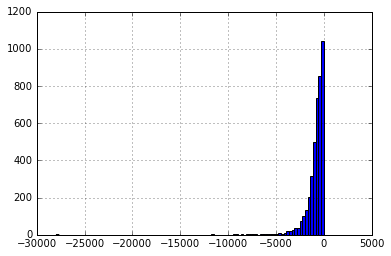

In [646]:
(total_ant_users['TOTAL_Origin_USERS'] - total_ant_users['EXP_Target_USERS']).hist(bins=100)

(1528, 12)

In [ ]:
#swapeo los nombres de las columnas, dropeo epidemic y lo vuelvo a agregar para los nuevos users swappeados
table=table.rename(columns = {'LineKeyOrigin':'LineKeyTarget','ANTENNA_ID':'ANTENNA_ID_0',
                        'LineKeyTarget':'LineKeyOrigin','ANTENNA_ID_0':'ANTENNA_ID'})
#la info epidemica era para el viejo lineKeyOrigin. droppeo esa columna vieja y agrego la info para el nuevo Origin
table.drop('EPIDEMIC',inplace=True,axis=1)
antennas= pd.read_csv('/home/juan/mobility-study/antennas_mexico.csv',sep = "|",header=0,index_col=None)
table = table.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0_Target',how='left')
finished2=True

In [ ]:
antenna_table2 = table.groupby(['ANTENNA_ID_0','ANTENNA_ID_0_Target'],sort=False)[cols].sum()
antenna_table2.drop('EPIDEMIC',inplace=True,axis=1)
#test  =  test.groupby(['LineKeyOrigin','EPIDEMIC'],sort=False)[cols].sum()
antenna_table2.reset_index([0,1],inplace=True)
antenna_table2.sort_values(by='ANTENNA_ID_0',inplace=True,ascending=True)

In [ ]:
antenna_table2 = antenna_table2.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0_Target',how='left')

### Sanity checking im not losing users
hicimos una comparacion de la tabla antes y despues de la ultima linea de codigo y da que
len(np.unique(table.LineKeyOrigin.values)) == 640647
len(np.unique(test.index.levels[0].values)) == 640647

In [136]:
antenna_table.head()

,ANTENNA_ID_0,ANTENNA_ID_0_Target,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC
1232115,1,973,20,0,0,2733,0,0,0
395937,1,3858,0,0,1,0,0,476,0
395936,1,2641,0,1,0,0,202,0,1
318028,1,77,0,1,0,0,74,0,1
853768,1,2854,0,0,1,0,0,47,1


In [27]:
i = random.randint(0,9200)
antenna_table.iloc[i:i+4,].groupby('ANTENNA_ID_0').apply(get_epidemic_agregator)

,,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI
ANTENNA_ID_0,,,,,,,,,,,,,
11,0,49,28,18,4465,3990,1183,34,10,4,1641,361,170


In [28]:
antenna_table.iloc[i:i+4,]

,ANTENNA_ID_0,ANTENNA_ID_0_Target,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC
36978,11,2985,6,3,0,300,145,0,1
18947,11,1955,0,0,1,0,0,51,0
30970,11,1453,15,18,13,2824,3629,962,0
31988,11,230,28,7,4,1341,216,170,1


In [28]:
start_time = time.time()
antenna_table=antenna_table.groupby('ANTENNA_ID_0').apply(get_epidemic_agregator)
antenna_table.reset_index(level=1,inplace=True)
antenna_table.drop('level_1',axis=1,inplace=True)
time.time()-start_time

24.560290813446045

In [45]:
verify= antenna_table.sample(20)
ind = verify.index.values
ind

array([1354, 3710,  942, 3121, 3686, 1316, 3715,  290, 1914,  175,  136,
       2191,  602,  501, 3020, 2105, 2235,  686, 1358, 1449])

In [279]:
user = 1354
antenna_table[antenna_table['ANTENNA_ID_0'] == user]

,ANTENNA_ID_0,ANTENNA_ID_0_Target,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,EPIDEMIC
1567,3402,1378,1,0,0,32,0,0,0
7990,3402,3227,1,0,0,24,0,0,0
7596,3402,3402,0,0,2,0,0,36,0


In [280]:
verify.loc[user]

CallsWeekDaylight         2
CallsWeekNight            0
CallsWeekend              2
TimeWeekDaylight         56
TimeWeekNight             0
TimeWeekend              36
CallsWeekDaylight_EPI     0
CallsWeekNight_EPI        0
CallsWeekend_EPI          0
TimeWeekDaylight_EPI      0
TimeWeekNight_EPI         0
TimeWeekend_EPI           0
Name: 3402, dtype: int64

In [29]:
antenna_table.reset_index(level=0,inplace=True)
antenna_table = antenna_table.join(antennas['EPIDEMIC'], on='ANTENNA_ID_0',how='left')
antenna_table.head()

,ANTENNA_ID_0,CallsWeekDaylight,CallsWeekNight,CallsWeekend,TimeWeekDaylight,TimeWeekNight,TimeWeekend,CallsWeekDaylight_EPI,CallsWeekNight_EPI,CallsWeekend_EPI,TimeWeekDaylight_EPI,TimeWeekNight_EPI,TimeWeekend_EPI,EPIDEMIC
0,1,6539,3189,3169,53972,42050,44656,3989,1832,1760,14042,22740,18573,1
1,2,6336,3598,3420,19025,47471,16603,3559,1852,1893,11533,50915,3744,1
2,3,8958,4688,4118,43640,5215,38762,4545,2234,2187,64471,41947,48825,1
3,4,4360,2782,2719,49870,65048,54122,2105,1563,1415,16605,7948,39523,1
4,5,2807,1610,1787,38676,47700,11503,1420,899,906,336,13666,15146,1


In [31]:
#finalmente pego la info de antenna_users a la tabla
antenna_table = antenna_table.join(antenna_users[['TOTAL_USERS','VULN_USERS']], on='ANTENNA_ID_0',how='left')

In [35]:
antenna_table[antenna_table['EPIDEMIC']==0].shape

(2794, 16)

In [32]:
antennas.shape, antenna_table.shape

((4429, 5), (4171, 16))

In [33]:
#guardo la info de antennas
antenna_table.to_csv('/home/juan/mobility-study/mexico_antennas_vulns.txt', 
            index = False, 
             header = True,
             sep="|")

### Testing get_epidemic_aggregator
Corrimos este algoritmo con un sample de mil lineas y comparamos especificamente para aquellos usuarios que tenian caracteristicas de EPIDEMIC==1, con lo cual testeamos a ver si estaba resultando bien o no el siguiente apply en estos casos cruciales (los otros eran mas simples).

## get_epidemic_aggregator apply on users Table

### Para optimizar el apply:
mejor correrlo directamente sobre usuarios que tengan algun epidemic ==0 pues estos van a dar resultados diferentes mientras que los otros usarios simplemente "extenderian" la tabla con 0s hacia las columnas _EPIDEMIC . 

En algunos casos el 80% de la tabla son usuarios que NO tienen info epidemica.

#### Timings del cell abajo
6 mins para 180k users

4 mins para 40k users

80s para 40k users

70 mins para 1.2M

In [320]:
table.shape

(5015519, 11)

# General epidemic_aggregator algorithm

In [329]:
finished1, finished2, finished3 = [False]*3

In [ ]:
start_time = time.time()

new_cols =[col+"_EPI" for col in table.columns.values \
           if (not('EPIDEMIC ' in col) and not('Line' in col) and not('ANTENNA' in col) )]
#seteo todas las nuevas columnas en 0 y dropeo EPIDEMIC
only_non_epidemic_users = list(set(table[table['EPIDEMIC']==0].LineKeyOrigin.values) - set(table[table['EPIDEMIC']==1].LineKeyOrigin.values))

#test 2 se lleva los usuarios mixtos y test3 los "puros" non_epi
test2 = table[~table['LineKeyOrigin'].isin(only_non_epidemic_users)].copy()
test3 = table[table['LineKeyOrigin'].isin(only_non_epidemic_users)].copy()

for col in new_cols:
    test3[col]=0
    #test3.loc[test['LineKeyOrigin'].isin(only_non_epidemic_users),col]=0
test3.drop([col for col in test3.columns if ('EPIDEMIC' in col)],inplace=True,axis=1)
#paso el linekeyorigin a indice y dropeo esa columna
test3 = test3.groupby('LineKeyOrigin').sum()
# uso el agregador en el resto de los users
print("finished setting pure epidemic users, current time is {t} \n".\
              format(t=(time.time()-start_time))) 
test2 =test2.groupby('LineKeyOrigin').apply(get_epidemic_agregator)
#seteo bien el indice a LineKeyOrigin y dropeo el level 1 del multi
test2.reset_index(level=1,drop=True,inplace=True)
#finalmente concateno las dos tablas
test = pd.concat([test3,test2])
test.reset_index(level=0,drop=False,inplace=True)

start_time = time.time()
elapsed_time = time.time()-start_time

print("total algo time for {n} users is {t}".format(n=(len(test2)+len(test3)), t= elapsed_time))
finished1 =True

In [396]:
[col for col in table.columns if ('Line' in col) or ('EPIDEMIC' in col) or ('ANTENNA' in col)]

['LineKeyOrigin',
 'LineKeyTarget',
 'EPIDEMIC',
 'ANTENNA_ID_0',
 'EPIDEMIC_Target',
 'ANTENNA_ID_0_Target']

## Repetimos el algoritmo anterior pero ahora swapeando la info

In [ ]:
#swapeo los nombres de las columnas, dropeo epidemic y lo vuelvo a agregar para los nuevos users swappeados
table=table.rename(columns = {'LineKeyOrigin':'LineKeyTarget','ANTENNA_ID_0':'ANTENNA_ID_0_Target',
                        'LineKeyTarget':'LineKeyOrigin','ANTENNA_ID_0_Target':'ANTENNA_ID_0'})

#la info epidemica era para el viejo lineKeyOrigin. droppeo esa columna vieja y agrego la info para el nuevo Origin
table.drop('EPIDEMIC',inplace=True,axis=1)
antennas= pd.read_csv('/home/juan/mobility-study/antennas_mexico.csv',sep = "|",header=0,index_col=None)
table = table.join(user_epidemic['EPIDEMIC'], on='LineKeyTarget',how='left')
finished2=True

In [ ]:
start_time = time.time()

new_cols =[col+"_EPI" for col in table.columns.values \
           if (col != 'EPIDEMIC' and not('Line' in col) and not('ANTENNA' in col) )]
#seteo todas las nuevas columnas en 0 y dropeo EPIDEMIC
only_non_epidemic_users = list(set(table[table['EPIDEMIC']==0].LineKeyOrigin.values) - set(table[table['EPIDEMIC']==1].LineKeyOrigin.values))

#test 2 se lleva los usuarios mixtos y test3 los "puros" non_epi
test2 = table[~table['LineKeyOrigin'].isin(only_non_epidemic_users)].copy()
test3 = table[table['LineKeyOrigin'].isin(only_non_epidemic_users)].copy()

for col in new_cols:
    test3[col]=0
    #test3.loc[test['LineKeyOrigin'].isin(only_non_epidemic_users),col]=0
test3.drop('EPIDEMIC',inplace=True,axis=1)
#paso el linekeyorigin a indice y dropeo esa columna
test3 = test3.groupby('LineKeyOrigin').sum()
# uso el agregador en el resto de los users
print("finished setting pure epidemic users, current time is {t} \n".\
              format(t=(time.time()-start_time))) 
test2 =test2.groupby('LineKeyOrigin').apply(get_epidemic_agregator)
#seteo bien el indice a LineKeyOrigin y dropeo el level 1 del multi
test2.reset_index(level=1,drop=True,inplace=True)
#finalmente concateno las dos tablas + el viejo test
test2.reset_index(level=0,drop=False,inplace=True)
test3.reset_index(level=0,drop=False,inplace=True)

test = pd.concat([test,test3,test2])
labels = [col for col in test.columns if (col != 'EPIDEMIC' and not('Line' in col) and not('ANTENNA' in col) )]
test = test.groupby(["LineKeyOrigin",], as_index=True)[labels].sum()

elapsed_time = time.time()-start_time
print("total algo time for {n} users is {t}".format(n=(len(test2)+len(test3)), t= elapsed_time))
finished3=True


## Falta agregar la info de Total vs Vuln_users interaction

In [437]:
start_time = time.time()
# me genero la tabla con los pares (i,j) y concateno con la tabla pero swappeando en (j,i) para lograr hacer los counts apropiados

user_pair = table.loc[:,['LineKeyOrigin','LineKeyTarget']]
user_pair2 = user_pair.loc[:,['LineKeyTarget','LineKeyOrigin']]
user_pair2.columns = ['LineKeyOrigin','LineKeyTarget']
user_pair = pd.concat([user_pair,user_pair2])
#agrego la informacion epidemica y de exposicion
user_pair = user_pair.join(user_epidemic[['EPIDEMIC','EXPOSED']],on = 'LineKeyTarget', how = 'left')
del user_pair2

# UNIQUE # of users count

#primero agrupo por el par (i,j) para no tener dos veces el par y agrupo 
#(el agregador es "bobo" no voy a estar usando la info de esta agrupacion)
total_users = user_pair.groupby(['LineKeyOrigin','LineKeyTarget']).agg({"TOTAL_USERS":np.sum})
total_users = total_users.reset_index()
# ahora conteo los usuarios unicos
total_users = total_users.groupby('LineKeyOrigin')['TOTAL_USERS'].count()
total_users = total_users.to_frame()
total_users = total_users.reset_index()

# EPIDEMIC & EXPOSED count
#primero agrupo por el par (i,j) para no tener dos veces el par y agrupo 
#(el agregador es "bobo" no voy a estar usando la info de esta agrupacion)

epidemic_count = user_pair[user_pair['EPIDEMIC']==1]\
                .groupby(['LineKeyOrigin','LineKeyTarget'])['EPIDEMIC'].agg({"EPI_USERS":np.sum})
exposed_count = user_pair[user_pair['EXPOSED']==1]\
                .groupby(['LineKeyOrigin','LineKeyTarget'])['EXPOSED'].agg({"EXP_USERS":np.sum})
#reseteo el indice
epidemic_count = epidemic_count.reset_index()
exposed_count = exposed_count.reset_index()

#ahora si agrupo y cuento c/ par unico (Origin,Target)
epidemic_count = epidemic_count.groupby(['LineKeyOrigin'])['EPI_USERS'].count()
exposed_count = exposed_count.groupby(['LineKeyOrigin'])['EXP_USERS'].count()

epidemic_count = epidemic_count.to_frame()
exposed_count = exposed_count.to_frame()



del user_pair

#agrego la informacion epidemica y de exposicion en total_users y relleno los NaNs con 0s i.e. ausencia de conteos
total_users = total_users.join(epidemic_count['EPI_USERS'],on = 'LineKeyOrigin', how = 'left').fillna(0)
total_users = total_users.join(exposed_count['EXP_USERS'],on = 'LineKeyOrigin', how = 'left').fillna(0)

del exposed_count, epidemic_count

total_users.set_index('LineKeyOrigin',inplace=True)

elapsed_time = time.time()-start_time
print("total algo time for {n} users is {t}".format(n=(len(total_users)), t= elapsed_time))

total algo time for 2449242 users is 115.642934084


## Sanity check
Chequeamos cantidad de usuarios en la tabla resultante y algunos casos particulares al azar

In [443]:
total_users.sample(5)

,TOTAL_USERS,EPI_USERS,EXP_USERS
LineKeyOrigin,,,
A97A6025FAA09766D13886C1CE71F557,3,1,3
5F60685185C7482A4FFDE9AF67226C6B,1,0,1
1F54EBA091172CFAEB39765083A9D46E,3,2,3
794533D066894168E2B3E43D871F76F5,1,0,1
36FF13B622D14481871874B522D0A35B,2,2,2


In [444]:
user = "1F54EBA091172CFAEB39765083A9D46E"

In [445]:
user_epidemic.loc[user,:]

EXPOSED          True
ANTENNA_ID_0     1714
EPIDEMIC        False
Name: 1F54EBA091172CFAEB39765083A9D46E, dtype: object

In [446]:
antennas[antennas['ID'] ==1714]

,ID,LATITUDE,LONGITUDE,STATE,EPIDEMIC
900,1714,19.28,-98.881,Mexico,0


In [451]:
relevant_cols = [col for col in table.columns if ('Line' in col) or ('EPIDEMIC' in col) or ('ANTENNA' in col) ]
table[table['LineKeyTarget']==user][relevant_cols]

,LineKeyOrigin,LineKeyTarget,EPIDEMIC,ANTENNA_ID_0,EPIDEMIC_Target,ANTENNA_ID_0_Target
1192878,3D1A6506142965F390124F4CED1C89A5,1F54EBA091172CFAEB39765083A9D46E,True,2161,False,1714


In [452]:
table[table['LineKeyOrigin']==user][relevant_cols]

,LineKeyOrigin,LineKeyTarget,EPIDEMIC,ANTENNA_ID_0,EPIDEMIC_Target,ANTENNA_ID_0_Target
611238,1F54EBA091172CFAEB39765083A9D46E,1DA8375FAEEA1F30C3AD2DC5829AC918,False,1714,True,1658
611239,1F54EBA091172CFAEB39765083A9D46E,3D1A6506142965F390124F4CED1C89A5,False,1714,True,2161
611240,1F54EBA091172CFAEB39765083A9D46E,D6187EFCF1D30F9244059E0164338B45,False,1714,False,1510


### Fast sanity_check number of users.

In [453]:
total_users.shape,len(np.unique(total_users.index.values)) 

((2449242, 3), 2449242)

In [455]:
len(set(np.unique(table.LineKeyOrigin.values))  | set(np.unique(table.LineKeyTarget.values)) )

2449242

In [456]:
len(np.unique(test.index.values)), test.shape

(2449242, (2449242, 12))

### Results

In [462]:
pd.Series.hist?

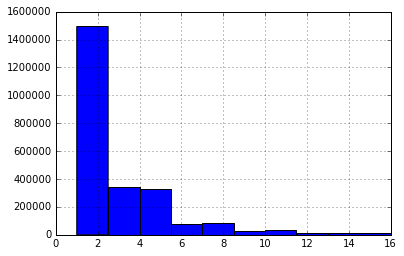

In [468]:
total_users[total_users['TOTAL_USERS'] < total_users.TOTAL_USERS.quantile(0.99)]['TOTAL_USERS'].hist()

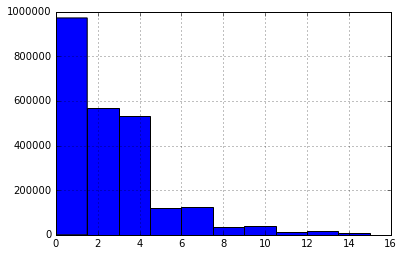

In [469]:
total_users[total_users['EXP_USERS'] < total_users.EXP_USERS.quantile(0.99)]['EXP_USERS'].hist()

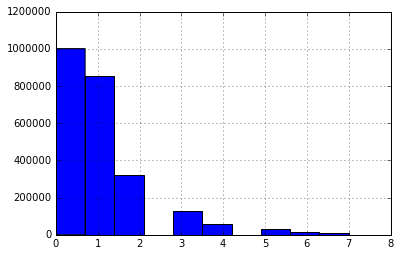

In [470]:
total_users[total_users['EPI_USERS'] < total_users.EPI_USERS.quantile(0.99)]['EPI_USERS'].hist()

## add Info to output table

In [471]:
test2 = pd.merge(test,total_users,how='inner',right_index=True,left_index=True)

In [473]:
test.shape, test2.shape

((2449242, 12), (2449242, 15))

In [478]:
#guardo por las dudas para levantar mas rapido a futuro
test2.to_csv(output_file, 
             index = True, 
             header = True,
             float_format='%.0f',
             sep="|")

In [479]:
!head $output_file 

LineKeyOrigin|CallsWeekDaylight|CallsWeekDaylight_EPI|CallsWeekNight|CallsWeekNight_EPI|CallsWeekend|CallsWeekend_EPI|TimeWeekDaylight|TimeWeekDaylight_EPI|TimeWeekNight|TimeWeekNight_EPI|TimeWeekend|TimeWeekend_EPI|TOTAL_USERS|EPI_USERS|EXP_USERS
000004F96010462FA7A71C7784E27476|0|0|0|0|0|1|0|0|0|0|0|34|1|0|1
000007EEE7895E17937CFF86379C8E17|0|2|0|0|0|0|0|144|0|0|0|0|1|1|1
00000837B868F926F67BD440A0845C1D|1|0|2|4|3|0|47|0|74|86|109|0|3|0|2
00000C5D3BFBEBD919F6F68386C3DD5E|4|0|0|0|0|0|281|0|0|0|0|0|1|0|1
0000129F4191FFD0963774D2307C7510|2|0|0|0|0|0|66|0|0|0|0|0|2|0|2
000017368A8964F8C71A9F3A1EAF6160|7|4|0|0|1|0|960|630|0|0|58|0|4|1|4
00001ADC8C5705AB4FD8197B5024C1AA|7|1|5|5|4|1|744|29|207|335|218|141|4|2|4
00001B448AE41076EB2C58ABEAF0E0C8|15|0|12|1|10|1|1319|0|705|31|459|29|2|1|2
00001C544BEBBB9109CE3552B4CDC490|0|0|1|0|0|0|0|0|36|0|0|0|1|0|1


In [481]:
!gzip -f $output_file

In [484]:
!du -ha $output_file* 

76M	/home/juan/mobility-study/output_sum_links.txt.gz


### Sanity checking im not losing users in the algorithm

In [29]:
test.head()

,CallsWeekDaylight,CallsWeekDaylight_EPI,CallsWeekNight,CallsWeekNight_EPI,CallsWeekend,CallsWeekend_EPI,TimeWeekDaylight,TimeWeekDaylight_EPI,TimeWeekNight,TimeWeekNight_EPI,TimeWeekend,TimeWeekend_EPI
LineKeyOrigin,,,,,,,,,,,,
000004F96010462FA7A71C7784E27476,0,0,0,0,0,1,0,0,0,0,0,34
000007EEE7895E17937CFF86379C8E17,0,2,0,0,0,0,0,144,0,0,0,0
00000837B868F926F67BD440A0845C1D,1,0,2,4,3,0,47,0,74,86,109,0
00000C5D3BFBEBD919F6F68386C3DD5E,4,0,0,0,0,0,281,0,0,0,0,0
0000129F4191FFD0963774D2307C7510,2,0,0,0,0,0,66,0,0,0,0,0


In [30]:
test_hashes = np.unique(test.index.values)

In [31]:
test.shape, len(test_hashes)

((2449242, 12), 2449242)

In [28]:
len(simple_format_hashes)

3667451

In [ ]:
table.shape, test.shape, test2.shape,test3.shape

In [208]:
1927239== 712128 +1215111

True

In [33]:
only_non_epidemic_users = list(set(table[table['EPIDEMIC']==0].LineKeyOrigin.values) - set(table[table['EPIDEMIC']==1].LineKeyOrigin.values))

In [36]:
print(table.shape)
print(table[~table['LineKeyOrigin'].isin(only_non_epidemic_users)].shape)
print(table[table['LineKeyOrigin'].isin(only_non_epidemic_users)].shape)

(5015519, 11)
(1862025, 11)
(3153494, 11)


In [38]:
(table['LineKeyOrigin'].isin(only_non_epidemic_users).isnull()).any()

False

In [39]:
non_epi_hashes =np.unique(table[~table['LineKeyOrigin'].isin(only_non_epidemic_users)].LineKeyOrigin.values)
epi_hashes = np.unique(table[table['LineKeyOrigin'].isin(only_non_epidemic_users)].LineKeyOrigin.values)
len(epi_hashes) + len(non_epi_hashes)

1927239

In [40]:
table_hashes = np.unique(table['LineKeyOrigin'].values)
print len(table_hashes)
print len(epi_hashes) + len(non_epi_hashes)

1927239
1927239


In [43]:
len(simple_format_hashes)

3667451

## Results
Levantamos en sum_links 1927239 usuarios de la Telco que tienen al menos 1 interaccion con otro users de la misma TelCo
Sin embargo en la tabla de simple_format ya procesada, tengo 3667451 users de la Telco.
Lo que creo que esta sucediendo es que hay 1.5M de users que NO hablan con otro usuario de la telco.... Raro.

Habria que testear en simple_format de levantar de vuelta los useres pertinentes asi nos

## More sanity checking
Obs.. podria estar pasando que estamos droppeando todas esas filas que eran interacciones unicamente por SMS (interaccion que no estamso mirando actualmente pues descartamos esas columnas directamente). Pero mirando el dato crudo con grep ( zcat sum_links_201504_201506.txt.gz | grep -m 10 "00000C5D3BFBEBD919F6F68386C3DD5E") encontramos users de la Telco que interactuan con este y en formato de llamadas, luego estamos perdiendo users en otro lado..

HAY QUE recorrer el algoritmo que levanta users para ver donde se estarian cayendo estas interacciones y rever si es el parser o si lo 'dropeamos' el valor en algun lado. La nueva tabla la vamos a guardar en la variable table justamente

In [239]:
test_hashes= test.index.values

In [241]:
print(len(np.unique(test_hashes)))
print(len(test_hashes))

1927239
1927239


In [42]:
print(len(table_hashes))

1927239


In [286]:
np.in1d(table_hashes,test_hashes,assume_unique=True).all()

False

In [52]:
#me fijo aquellos que estan en la simple_f pero que no estan en la tabla
out_of_table_hashes = simple_format_hashes[~np.in1d(simple_format_hashes,table_hashes,assume_unique=True)]

In [56]:
out_of_table_hashes.shape

(1740212,)

#### buscamos con grep a estos users dentro de los sum_link files a ver que estaria pasando
* Las ultimas 3 filas son de sms con lo cual NO se incluyen en nuestro procesamiento de sum_links
* Tmb podria pasar que haya una interaccion entre dos usuarios, unos de los cuales no es de la Telco, luego se excluye esta linea.


In [98]:
i=random.randint(0,len(out_of_table_hashes)-1)
user = (out_of_table_hashes[i])
slinks_file1 = "/grandata/voice/sum_links/sum_links_201504_201506.txt.gz"
slinks_file2 = "/grandata/voice/sum_links/sum_links_201507_201509.txt.gz"
user

'F8527ACF3BD6B2E6664FEB7993820E8D'

In [99]:
start_time = time.time()
!zcat $slinks_file1 | grep -m 10 "$user" 
elapsed_time = time.time()-start_time
print("total algo time for this cell is {t}".format( t= elapsed_time))

485AAB7A278EA2BC2B434386103B3CDD|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|1|0|0|58|0|0|0
299403B5EDEF0B0D6F42D7A09A8EDC39|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|0|0|0|0|1|1|0
F7A0CA7A5B32D2172B95A0ECE69C1622|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|0|0|0|0|0|1|0
80DBF1C2031A8A6400CC4A5367DB2F5B|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|1|0|0|1|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|80DBF1C2031A8A6400CC4A5367DB2F5B|2|0|0|48|0|0|0|0|0
E7B7DB6EBECA9C15063D3EA58BFE20C5|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|0|0|0|0|0|3|0
F8527ACF3BD6B2E6664FEB7993820E8D|39E50DC04A11501518F91D47F5E3B504|1|0|3|44|0|141|0|0|0
39E50DC04A11501518F91D47F5E3B504|F8527ACF3BD6B2E6664FEB7993820E8D|1|0|0|20|0|0|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|3F69156BBD56452D7DDF5D3FF1302F20|0|1|1|0|27|30|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|1CBE2653BC1D2985AC8BF2955EE935DA|0|0|0|0|0|0|0|0|1

gzip: stdout: Broken pipe
total algo time for this cell is 114.504776001


In [100]:
start_time = time.time()
!zcat $slinks_file2 | grep -m 10 "$user" 
elapsed_time = time.time()-start_time
print("total algo time for this cell is {t}".format( t= elapsed_time))

F8527ACF3BD6B2E6664FEB7993820E8D|19438BC43AA0A0CB76B1318377CA3EA6|0|0|0|0|0|0|11|0|0
D76AD351C6DC8FB1372F303247548DD2|F8527ACF3BD6B2E6664FEB7993820E8D|0|0|1|0|0|109|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|D76AD351C6DC8FB1372F303247548DD2|0|0|0|0|0|0|0|0|1
7BC568EDB9B2D918941E7EADBBD3A970|F8527ACF3BD6B2E6664FEB7993820E8D|2|1|2|416|43|91|0|0|0
A80EB03346181E8D557EEA6E6C82E98F|F8527ACF3BD6B2E6664FEB7993820E8D|121|27|61|25380|6273|12159|0|0|0
F8527ACF3BD6B2E6664FEB7993820E8D|8072C7CE1B843532FFC51DBDF6123C83|2|0|1|258|0|269|0|0|0
total algo time for this cell is 597.377434969


In [111]:
#test if other link is telco user
other_user = '8072C7CE1B843532FFC51DBDF6123C83'
other_user in simple_format_hashes

False

### Results
O eran solo interacciones por SMS o eran interacciones donde algun usuario del par ()i,j era no_Telco

### Por las dudas levantamos todos los hashes que encontremos en sum_links, donde al menos un user es Telco 
Lo unico que cambia es el & por un | final en el chequeo isin(simple_format_hashes)

In [37]:
a = (set(simple_format_hashes[100:200])&b) | a&b | (set(simple_format_hashes[300:400]) & set(simple_format_hashes[290:300]))

In [52]:
## leemos de a chunks todo el file y lo agregamos a la tabla con los valores que nos importan

#ver el tiempo que tarda
start_time = time.time()
table_hashes_set = set()
simple_format_set = set(simple_format_hashes)
#table = pd.DataFrame()
for month_start in ["04","07"]:
    year = "2015"
    print("\nreading month {m} of {tot_n} months, current time is {t} \n".\
              format(m= month_start,tot_n = 2,t=(time.time()-start_time)))
    #todos estos sum_links terminan 2 meses mas tardes
    month_end= "0"+str(int(month_start)+2)
    input_file= rootdir +"/sum_links_{y}{ms}_{y}{me}.txt.gz".format(y=year,ms=month_start,me=month_end)
    raw_table = pd.read_csv(input_file,
                         sep = "|", 
                         header =0,
                         index_col = None,
                         usecols = ['LineKeyOrigin', 'LineKeyTarget'],
                         chunksize = 6*10**7,    
                        engine = 'c',
                         lineterminator='\n',
                         skipinitialspace=True, 
                        error_bad_lines= False,
                        warn_bad_lines= True,
                        #dtype = {'CallsWeekDaylight':np.uint16,'CallsWeekNight':np.uint16,'CallsWeekend':np.uint16,
                        #                  'TimeWeekDaylight':np.uint16,'TimeWeekNight':np.uint16,'TimeWeekend':np.uint16}
                           )

    numb=0;
    for chunk in raw_table:
        numb+=1
        print("reading chunk #{n} of {tot_n}, current time is {t}".\
              format(n=numb,tot_n = 8,t=(time.time()-start_time))) 
        table_hashes_set |= set(chunk['LineKeyOrigin'].values)&(simple_format_set) | set(chunk['LineKeyTarget'].values)&(simple_format_set)
        #table = table.append()

#como leo varios meses puede haber dos ocurencias distintas para un par (origin,target)

print("\n total running time of script is %d " % (time.time() -  start_time))



reading month 04 of 2 months, current time is 1.74087095261 

reading chunk #1 of 8, current time is 406.557054996
reading chunk #2 of 8, current time is 701.653960943
reading chunk #3 of 8, current time is 924.011265039
reading chunk #4 of 8, current time is 1138.56422305
reading chunk #5 of 8, current time is 1294.23157096

reading month 07 of 2 months, current time is 1326.59937096 

reading chunk #1 of 8, current time is 1487.06844401
reading chunk #2 of 8, current time is 1710.70073485
reading chunk #3 of 8, current time is 1929.73881197
reading chunk #4 of 8, current time is 2150.85129404
reading chunk #5 of 8, current time is 2308.18230391


NameError: name 'table' is not defined

In [246]:
#esto dice que todos los hashes de la table inicial estan en el conjunto final de test
np.in1d(table_hashes,test_hashes,assume_unique=True).all()

True

In [55]:
len(table_hashes_set & simple_format_set),len(simple_format_set)

(3664648, 3667451)

In [252]:
out_of_table_hashes = simple_format_hashes[~np.in1d(simple_format_hashes,test_hashes,assume_unique=True)]

In [253]:
out_of_table_hashes[:10]

array(['000004F96010462FA7A71C7784E27476',
       '000007EEE7895E17937CFF86379C8E17',
       '00000C5D3BFBEBD919F6F68386C3DD5E',
       '000011F2BE4C5E7D456026CD791185B3',
       '0000129F4191FFD0963774D2307C7510',
       '00002365F59A06246C1CCD3A43CAC09F',
       '000027B6096C6F19310E90FEAD73762B',
       '00002B778CE130C58F44B3D00FF2CE64',
       '00003105C23E8692A295A5B225D16636',
       '00003E0B659DBBB237C1EA4E3ACF3A6C'], dtype=object)

### Result
practicamente no hay perdida de usuarios. Por lo que la caida de users en el dataset original viene por el lado de que
hay algunos telco_users que en esos 6 meses no hablan con NINGUN otro telco_user y solamente con gente fuera del dataset

Idem cuando miramos al azar un user particular y 'grepeamos' los archivos de sum_links. Al analizar los otros usuario s con los que tiene contacto resulta que son o solo contactos por SMS o solo contactos con non_telco_user

Encontramos 3664648 users en sum_links y originalmente parseamos 3667451 en simple_format